# Trabajo práctico 1 



**Human activity recognition**

https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones

https://github.com/FIUBA-Posgrado-Inteligencia-Artificial/intro_ia/tree/cohorte-6/clase_2/jupyterbooks/data

Bajarlo de acá: https://archive.ics.uci.edu/ml/machine-learning-databases/00240/

**MNIST**

    from sklearn.datasets import fetch_openml
    X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)


Deben maximizarse la cantidad de operaciones vectorizadas en las implementaciones.



## Ejercicio 1 - Implementar clase PCA con numpy
**Dataset** Human activity recognition

Tomar las primeras 63 componentes principales y calcular la varianza contemplada. Realizar las operaciones internas con numpy.linalg. 

### Primera parte: implementación de la clase PCA
También se verifica que entregue resultados similares a la clase PCA
de scikit-learn

In [9]:
import numpy as np
from sklearn.decomposition import PCA

class pcaPablo:
    
    def __init__(self, n_components=2):
        self.n_components = n_components
        self.components = None
        self.mean = None
        
    def fit(self, X):       
        # Step 1: mean and center
        X = X - np.mean(X)
        
        # Step 2: covariance matrix
        C = np.cov(X.T)
        
        # Step 3: avas and aves from the covariance matrix
        avas, aves = np.linalg.eig(C)
        
        # Step 4: sort in decreasing order the aves
        indexes = np.argsort(avas)[::-1]
        
        # Step 5: store first n aves (must transpose first)
        aves = aves.T
        self.components = aves[indexes][0:self.n_components]
                
    def transform(self, X):
        # Step 1: center again the dataset
        X = X - np.mean(X)
        
        # Step 2: project X over the components
        # we transpose the components again in order to match
        # the dot product dimensions
        return np.dot(X, self.components.T)


In [10]:
# Verificación de la salida de ambas implementaciones
# del algoritmo PCA
X = np.array([[0.8, 0.7],[0.1,-0.1]])

# sklearn's PCA implementation
pca = PCA(n_components=1)
pca.fit(X)
X_proj = pca.transform(X)
print("Projection from sklearn\n", X_proj)

# Homemade PCA implementation
pca_pablo = pcaPablo(n_components=1)
pca_pablo.fit(X)
X_proj_pablo = pca_pablo.transform(X)

print("Projection \"homemade\"\n", X_proj_pablo)

# Finalmente verifico que la salida de ambas implementaciones esté dentro
# de una cota de error
np.testing.assert_allclose(X_proj, X_proj_pablo, rtol=0.02)

Projection from sklearn
 [[-0.53150729]
 [ 0.53150729]]
Projection "homemade"
 [[-0.52445188]
 [ 0.5385627 ]]


Por lo tanto, verificamos que se obtienen resultados similares mediante ambas implementaciones

### Segunda parte: PCA sobre el dataset de Human Activity Recognition

In [13]:
import os
import pandas as pd

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

RANDOM_STATE = 24

# Carga de datos
X_train = np.loadtxt(os.path.join("data", "X_train.txt"))
y_train = np.loadtxt(os.path.join("data", "y_train.txt")).astype(int)
df = pd.DataFrame(data=X_train)

Tomamos 63 componentes


Text(0, 0.5, 'Total acumulado')

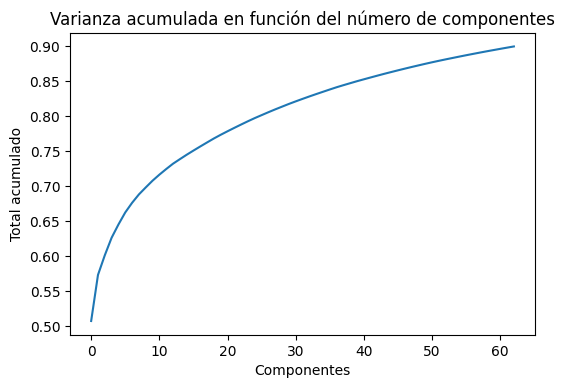

In [33]:
# Estandarización
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

# Tomo 63 componentes del dataset utilizando ambas implementaciones
pca = PCA(n_components=63, random_state=RANDOM_STATE).fit(X_scaled)
X_pca = pca.transform(X_scaled)

pca_pablo = pcaPablo(n_components=63)
pca_pablo.fit(X_scaled)
X_pca_pablo = pca_pablo.transform(X_scaled)
print("Tomamos {} componentes".format(X_pca_pablo.shape[1]))

plt.figure(dpi=100)
plt.plot(np.cumsum(pca.explained_variance_ratio_))

plt.title("Varianza acumulada en función del número de componentes")
plt.xlabel("Componentes")
plt.ylabel("Total acumulado")



Vemos que con 63 componentes se acumula el 90% de la varianza

Graficamos en 2D las primeras dos componentes

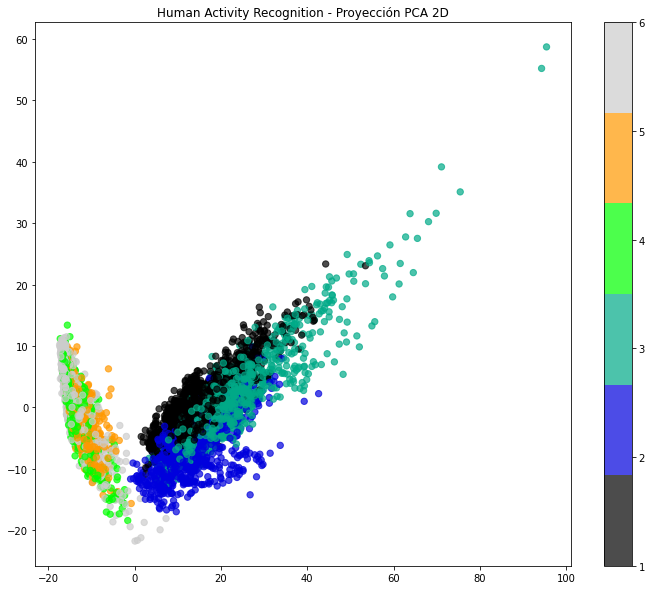

In [44]:
plt.figure(figsize=(12,10))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, alpha=0.7, s=40, cmap=plt.cm.get_cmap('nipy_spectral', 6))
plt.colorbar()
plt.title('Human Activity Recognition - Proyección PCA 2D');


## Ejercicio 2 - Implementar clase KMeans con numpy
**Dataset** Human activity recognition

Implementar kmeans con numpy. Agrupar el dataset transformado (ejercicio de PCA) y agrupar en clusters de k=2 y 6. Graficar los casos de k=2 y k=6 con las primeras dos componentes principales.

### Parte 1 - Implementación de K-Means

In [48]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(14)
m = X_scaled.shape[0] #data points
p = X_scaled.shape[1] #features
k = 6 #clusters
X = np.random.random((m,p))



class kmeansPablo:
    def __init__(self, K=5, max_iters=100, plot_steps=False):
        self.K = K
        self.max_iters = max_iters
        self.plot_steps = plot_steps

        # list of sample indices for each cluster
        self.clusters = [[] for _ in range(self.K)]
        # the centers (mean feature vector) for each cluster
        self.centroids = []
        self.iterations = 0

    def distance(self, x1, x2):
        return np.sqrt(np.sum((x1-x2)**2))
    
    def predict(self, X):
        self.X = X
        self.n_samples, self.n_features = X.shape

        # initialize
        random_sample_idxs = np.random.choice(self.n_samples, self.K, replace=False)
        self.centroids = [self.X[idx] for idx in random_sample_idxs]

        # Optimize clusters
        for _ in range(self.max_iters):
            self.iterations+=1
            
            # Assign samples to closest centroids (create clusters)
            self.clusters = self._create_clusters(self.centroids)

            if self.plot_steps:
                self.plot()

            # Calculate new centroids from the clusters
            centroids_old = self.centroids
            self.centroids = self._get_centroids(self.clusters)

            # check if clusters have changed
            if self._is_converged(centroids_old, self.centroids):
                print("Converged at {} iteration".format(self.iterations))
                break

            if self.plot_steps:
                self.plot()

        # Classify samples as the index of their clusters
        return self._get_cluster_labels(self.clusters)

    def _get_cluster_labels(self, clusters):
        # each sample will get the label of the cluster it was assigned to
        labels = np.empty(self.n_samples)

        for cluster_idx, cluster in enumerate(clusters):
            for sample_index in cluster:
                labels[sample_index] = cluster_idx
        return labels

    def _create_clusters(self, centroids):
        # Assign the samples to the closest centroids to create clusters
        clusters = [[] for _ in range(self.K)]
        for idx, sample in enumerate(self.X):
            centroid_idx = self._closest_centroid(sample, centroids)
            clusters[centroid_idx].append(idx)
        return clusters

    def _closest_centroid(self, sample, centroids):
        # distance of the current sample to each centroid
        distances = [self.distance(sample, point) for point in centroids]
        closest_index = np.argmin(distances)
        return closest_index

    def _get_centroids(self, clusters):
        # assign mean value of clusters to centroids
        centroids = np.zeros((self.K, self.n_features))
        for cluster_idx, cluster in enumerate(clusters):
            cluster_mean = np.mean(self.X[cluster], axis=0)
            centroids[cluster_idx] = cluster_mean
        return centroids

    def _is_converged(self, centroids_old, centroids):
        # distances between each old and new centroids, fol all centroids
        distances = [
            self.distance(centroids_old[i], centroids[i]) for i in range(self.K)
        ]
        return sum(distances) == 0

    def plot(self):
        fig, ax = plt.subplots(figsize=(5, 4))

        for i, index in enumerate(self.clusters):
            point = self.X[index].T
            ax.scatter(*point)

        for point in self.centroids:
            ax.scatter(*point, marker="x", color="black", linewidth=2)

        plt.show()



In [51]:
k = kmeansPablo(K=6, max_iters=100, plot_steps=False)
y_pred = k.predict(X_scaled)

print(y_pred)


Converged at 54 iteration
[5. 0. 5. ... 1. 1. 1.]


In [46]:
kmeans = KMeans(n_clusters=6, n_init=50, random_state=RANDOM_STATE)
kmeans.fit(X_pca)

KMeans(n_clusters=6, n_init=50, random_state=24)

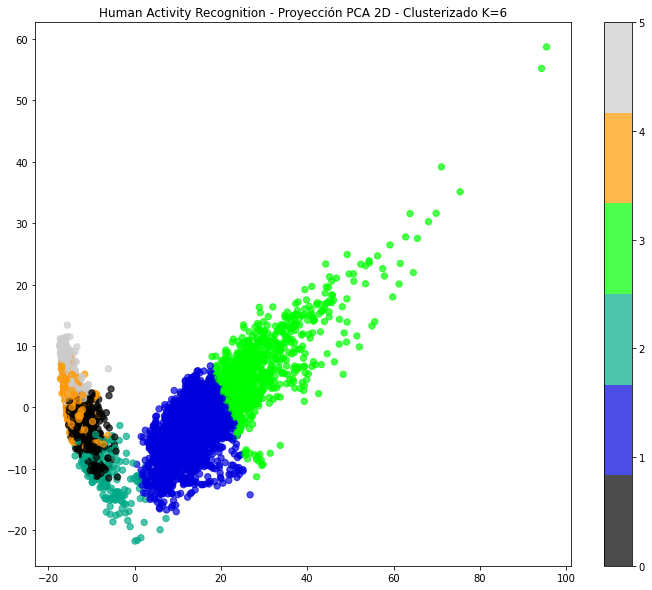

In [54]:
plt.figure(figsize=(12,10))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred, alpha=0.7, s=40, cmap=plt.cm.get_cmap('nipy_spectral', 6))
plt.colorbar()
plt.title('Human Activity Recognition - Proyección PCA 2D - Clusterizado K=6');

## Ejercicio 3 - Comparar los ejercicios anteriores con lo visto en las clases

Se observa una rotación de los datos en los diagramas 2D, con respecto a [este 
notebook](https://github.com/FIUBA-Posgrado-Inteligencia-Artificial/intro_ia/blob/cohorte-6/clase_2/jupyterbooks/PCA%20-%20Human%20Activity%20Recognition.ipynb)

## Ejercicio 4 - PCA + KMeans

**Dataset**: MNIST

Con las implementaciones de sklearn, tomar las componentes principales que capturen el 90% de la varianza y aplicar kmeans para agrupar los dígitos en 10 clusters. Analizar los resultados. 